# Imports

In [ ]:
!pip install plotly --upgrade
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install -q pyproj==1.9.6
!wget https://raw.githubusercontent.com/LesiaR/Datasets-base/main/quake.csv

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)
--2021-05-04 20:49:15--  https://raw.githubusercontent.com/LesiaR/Task3/main/quake.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44996 (44K) [text/plain]
Saving to: ‘quake.csv.1’

quake.csv.1         100%[===================>]  43.94K  --.-KB/s    in 0.001s  

2021-05-04 20:49:15 (46.0 MB/s) - ‘quake.csv.1’ saved [44996/44996]



In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import itertools

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
%matplotlib inline

import plotly
plotly.__version__

'4.14.3'

# Functions

In [ ]:
# Function for changing any feature values to corresponding quantile value
def assign_Q(df, column):
  Q1 = df[column].quantile(q = 0.25)
  Q2 = df[column].quantile(q = 0.50)
  Q3 = df[column].quantile(q = 0.75)
  Q4 = df[column].quantile(q = 1)
  print("Q1={} Q2={} Q3={} Q4={}".format(Q1, Q2, Q3, Q4))
  for i in df.index:
      val = df.loc[i, column]
      if val <= Q1:
        df.loc[i, column] = Q1
      elif (val > Q1) and (val <= Q2):
        df.loc[i, column] = Q2
      elif (val > Q2) and (val <= Q3):
        df.loc[i, column] = Q3
      else:
        df.loc[i, column] = Q4

In [ ]:
# Function for plotting the dendrogram
def plot_dendrogram(model, **kwargs):
  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        current_count += 1  # leaf node
      else:
        current_count += counts[child_idx - n_samples]
    counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

  # Plot the corresponding dendrogram
  dendrogram(linkage_matrix, **kwargs)
  
# Function for plotting dendrogram with description
def plot_dend(model):
  plt.figure(figsize=(30, 10))
  plt.title('Hierarchical Clustering Dendrogram')

  # plot the top three levels of the dendrogram
  plot_dendrogram(model, truncate_mode='level', p=5)
  plt.xlabel("Number of points in node (index of point if no parenthesis).")
  plt.grid(True)
  plt.xticks(fontsize=20, rotation=70)
  plt.show()

In [ ]:
# Function for visualization of Silhouette score from matplotlib
def plot_silhouette(X, n_clusters, labels): 
   # Create a subplot with 1 row and 2 columns
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_size_inches(18, 7)
      ax1.set_xlim([-0.1, 1])
      ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

      silhouette_avg = silhouette_score(X, labels)
      print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)
      sample_silhouette_values = silhouette_samples(X, labels)

      y_lower = 10
      for i in range(n_clusters):
          # Aggregate the silhouette scores for samples belonging to
          # cluster i, and sort them
          ith_cluster_silhouette_values = \
              sample_silhouette_values[labels == i]
          ith_cluster_silhouette_values.sort()
          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i
          color = cm.nipy_spectral(float(i) / n_clusters)
          ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

          # Label the silhouette plots with their cluster numbers at the middle
          ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
          y_lower = y_upper + 10  # 10 for the 0 samples


      ax2.scatter( x=X_2d[:,0], y=X_2d[:,1], c=labels,) 

# Data overview

Dataset contains information about earthquakes: coordinates, depth and strength. The task is to cluster the data.


In [ ]:
# Reading the data 
train = pd.read_csv('quake.csv')

In [ ]:
# Checking datatypes of features
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


As we can see from data information there are only numerical features in our dataset

In [ ]:
# Description of dataset
train.describe().T

count       mean         std  ...     50%     75%     max
Focal depth  2178.0  74.359963  116.467797  ...   39.00   68.00  656.00
Latitude     2178.0   7.961997   30.545583  ...    0.21   36.48   78.15
Longitude    2178.0  54.914835  118.875581  ...  122.10  146.86  180.00
Richter      2178.0   5.977181    0.189426  ...    5.90    6.10    6.90

[4 rows x 8 columns]

From statistical description that the biggest range is for focal depth features, which has outliers and Richter strenth varies pretty small from 5.8 to 6.9.

# EDA

Let's check some visualization for our dataset

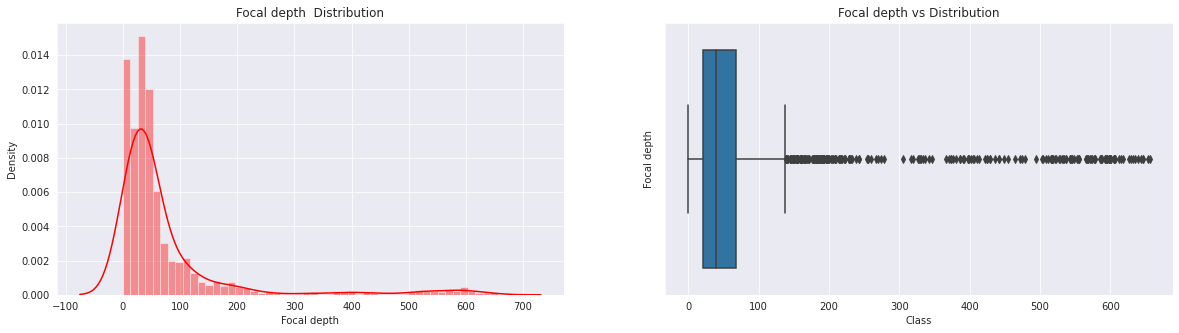

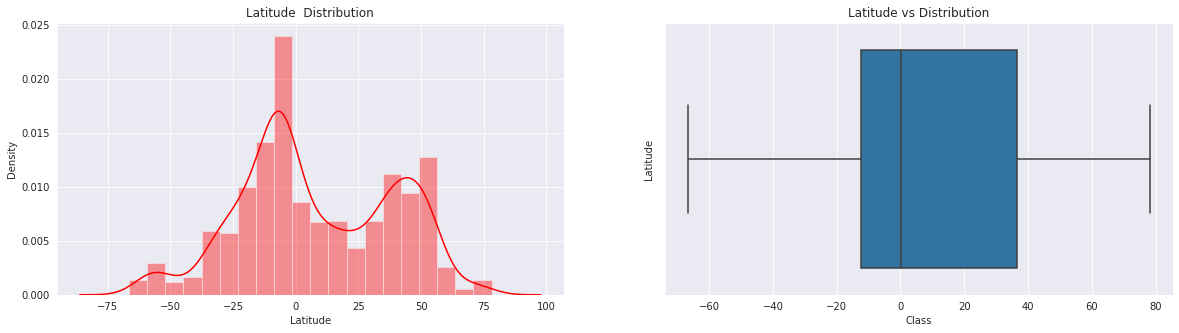

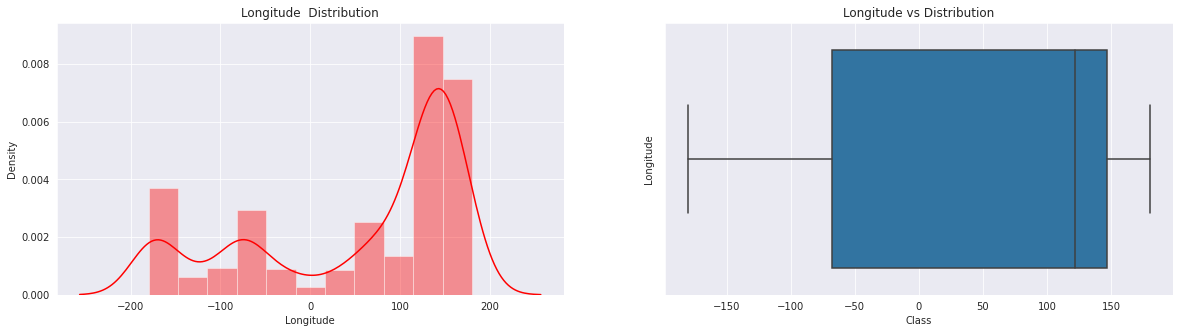

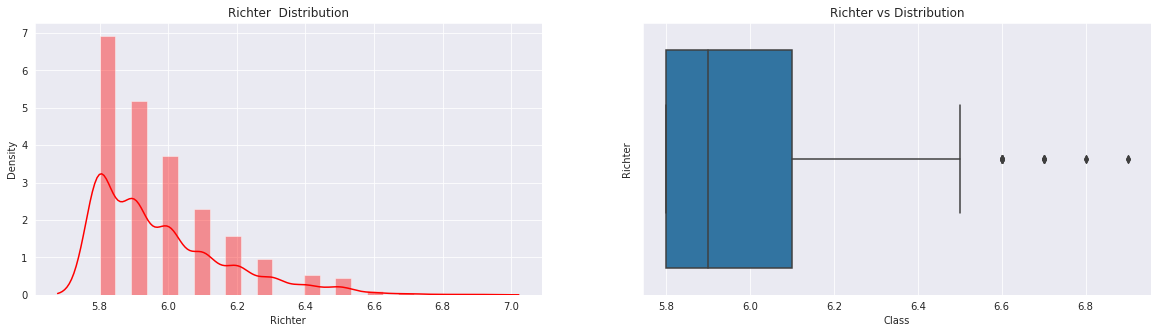

In [ ]:
# Visualization for numerical features distributions 

for column in train.columns:

    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    sns.distplot(train[column], color='r')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.title(f'{column}  Distribution')

    plt.subplot(1,2,2)
    sns.boxplot(x = column, data=train)
    plt.xlabel('Class')
    plt.ylabel(column)
    plt.title(f'{column} vs Distribution');

From this visualization we can see that neither feature is normally distributed, and scales are different, also focal depth and richter have outliers

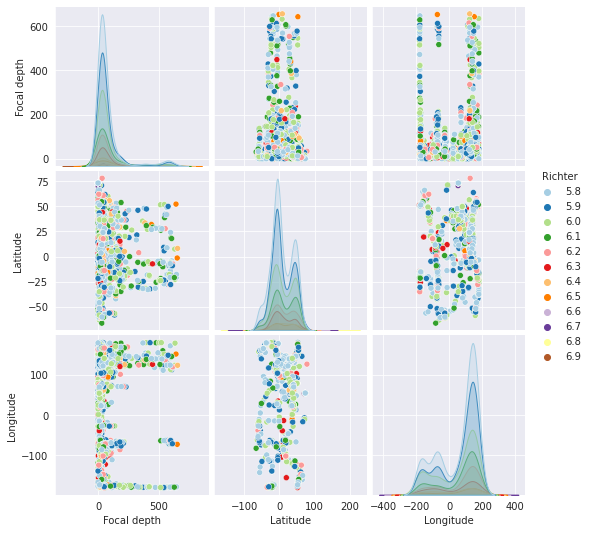

In [ ]:
# Visualization for features relations with Richter as hue parameter
columns = list(train.columns).remove('Richter')
sns.pairplot(
    train,
    x_vars=columns,
    y_vars=columns,
    hue='Richter',
    palette = 'Paired'
)

From pairplot it is visible that Focal depth influences on data clustering, and Richter not very 

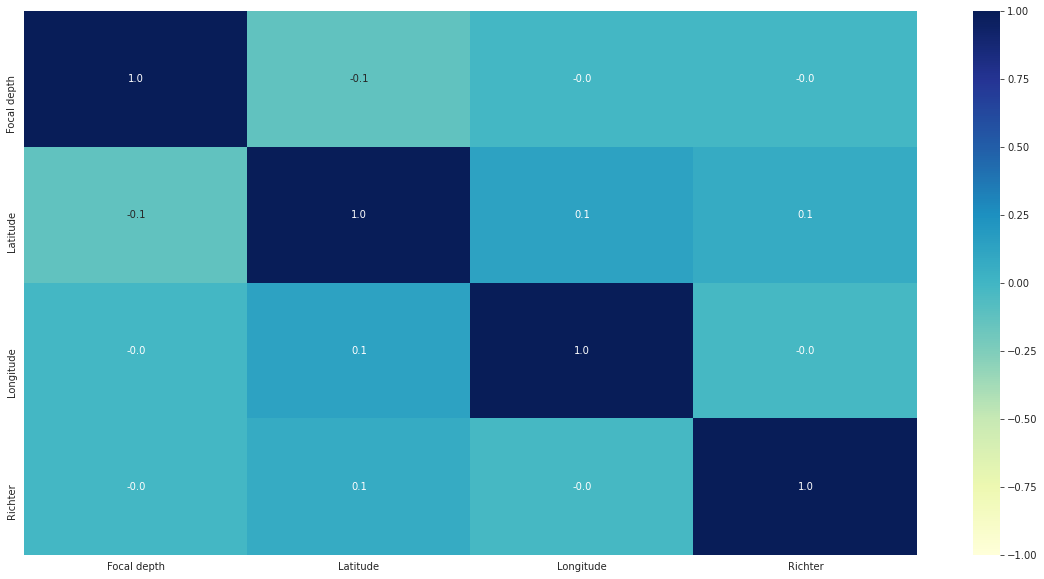

In [ ]:
# Visualization for correlation between numerical features
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(train.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap='YlGnBu')

We can see that there are no highly correlated features in dataset 

**Conclusions after EDA**:
* As features are represented in different scales we need to do some scaling
* Also for better data separation it is good to do some grouping od Focal depth and Richter feature
* For now no feature will be dropped as no highly correlated features were discovered

# Preprocessing

## Missing values

In [ ]:
# Percentage of missing values for each feature
train.isna().sum()/len(train)

Focal depth    0.0
Latitude       0.0
Longitude      0.0
Richter        0.0
dtype: float64

There are no missing values in dataset

## Grouping

In [ ]:
# Creating copy of main dataset before grouping
X=train.copy()

In [ ]:
# Grouping Richter feature into 4 quartiles
assign_Q(X, 'Richter')
X.Richter.unique()

Q1=5.8 Q2=5.9 Q3=6.1 Q4=6.9


array([6.9, 5.8, 6.1, 5.9])

In [ ]:
# Grouping Focal depth feature into 4 quartiles
assign_Q(X, 'Focal depth')
X['Focal depth'].unique()

Q1=21.0 Q2=39.0 Q3=68.0 Q4=656.0


array([ 39.,  68.,  21., 656.])

## Scaling

For scaling MinMaxScaler was selected as our data is not normally distributed

In [ ]:
# Scaling data with MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## DR

In [ ]:
# DR with PCA method to 2 dimentions
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
X['pca_x'], X['pca_y'] = X_2d[:, 0], X_2d[:, 1]

# K-means model

In [ ]:
# K-means model with 15 clusters
kmeans = KMeans(n_clusters=15, random_state=0)
y_kmeans = kmeans.fit_predict(X_scaled)

In [ ]:
# Mapping dictionary for k-means labels
kmeans_labels_mapping = dict(zip([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], ['label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'label_10', 'label_11', 'label_12', 'label_13', 'label_14']))

In [ ]:
# Assigning cluster's labels
X['kmeans_label'] = pd.Series(y_kmeans).map(kmeans_labels_mapping)

In [ ]:
# Visualization for 15 clusters model
fig = px.scatter(X, x='pca_x', y='pca_y', color='kmeans_label')
fig.update_layout(title='Earthquake data in 2d PCA space (KMeans labels)')
fig.show()

From visualization we can see that 15 is not good variant for clustering, so we need to try better number

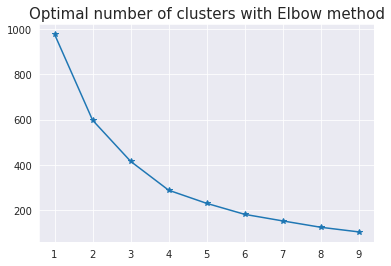

In [ ]:
# Finding optimal number of clusters with elbow method
inertias = []
n_clust_grid = [i for i in range(1, 10)]
for n_clusters in n_clust_grid:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(n_clust_grid, inertias, marker="*")
plt.title('Optimal number of clusters with Elbow method', fontsize=15);

* From plot above I would say that 4 or 6 are optimal number of clusters, but visually 4 is more intuitive
* I've tried 4 and it gave me 1 cluster for 2 visual clusters in the right, that's why I've decided to go with 5 as visually it looks better

In [ ]:
# Model with optimal number of clusters
kmeans = KMeans(n_clusters=5, random_state=0)
y_kmeans = kmeans.fit_predict(X_scaled)
X['ground_truth'] = pd.Series(y_kmeans).map(kmeans_labels_mapping)

In [ ]:
# Visualization for 5 clusters model
fig = px.scatter(X, x='pca_x', y='pca_y', color='ground_truth')
fig.update_layout(title='Earthquake data in 2d PCA space (KMeans labels)')
fig.show()

* In this model clustering still is not perfect, but we should take into account that this is after DR, so real data is 4 dimentional and can form 2 clusters in the left lower coner
* With 4 clusters model it was almost the same, just right 2 clusters were connected in one which is not totally correct from visual representation

# DBSCAN

To improve clustering few additional algorythms will be used, first one DBSCAN

In [ ]:
# Mapping dictionary for dbscan labels
dbscan_labels_mapping = dict(zip([-1, 0, 1, 2, 3, 4, 5, 6], ['OUTLIER', 'label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6']))

To tune hyperparameters will use synthetic grid and check how it looks visually for every variant. Only clustering max to 6 clusters is taken into considaration as it doesn't looks like data has more of them

In [ ]:
# Creating grid with hyperparameters values
epsilon_param_options = np.arange(0.2, 1, 0.1)
min_samples_param_options = np.arange(10, 40, 5)
param_grid = itertools.product(epsilon_param_options, min_samples_param_options)

In [ ]:
# Loop for assigning labels after building dbscan models with different hyperparameters
for element in param_grid:
  e = element[0]
  m = element[1]
  dbscan = DBSCAN(eps=e, min_samples=m)
  y_dbscan = dbscan.fit_predict(X_scaled)
  X['dbscan_label'] = pd.Series(y_dbscan).map(dbscan_labels_mapping)
  if len(X.dbscan_label.unique())<7:
     e = "{:.2f}".format(e)
     label = f'dbs {e}, {m}'
     X[label] = pd.Series(y_dbscan).map(dbscan_labels_mapping)
    

In [ ]:
# List of columns for plotting
dbs_columns = [['dbs 0.30, 10', 'dbs 0.30, 15'], ['dbs 0.30, 20', 'dbs 0.30, 25'],
               ['dbs 0.30, 30', 'dbs 0.30, 35'], ['dbs 0.40, 10', 'dbs 0.40, 15'],
               ['dbs 0.40, 20', 'dbs 0.40, 25'], ['dbs 0.40, 30', 'dbs 0.40, 35'],
               ['dbs 0.50, 10', 'dbs 0.50, 15'], ['dbs 0.50, 20', 'dbs 0.50, 25'],
               ['dbs 0.50, 30', 'dbs 0.50, 35'], ['dbs 0.60, 10', 'dbs 0.60, 15'],
               ['dbs 0.60, 20', 'dbs 0.60, 25'], ['dbs 0.60, 30', 'dbs 0.60, 35'],
               ['dbs 0.70, 10', 'dbs 0.70, 15'], ['dbs 0.70, 20', 'dbs 0.70, 25'],
               ['dbs 0.70, 30', 'dbs 0.70, 35'], ['dbs 0.80, 10', 'dbs 0.80, 15'],
               ['dbs 0.80, 20', 'dbs 0.80, 25'], ['dbs 0.80, 30', 'dbs 0.80, 35'],
               ['dbs 0.90, 10', 'dbs 0.90, 15'], ['dbs 0.90, 20', 'dbs 0.90, 25'],
               ['dbs 0.90, 30', 'dbs 0.90, 35']]

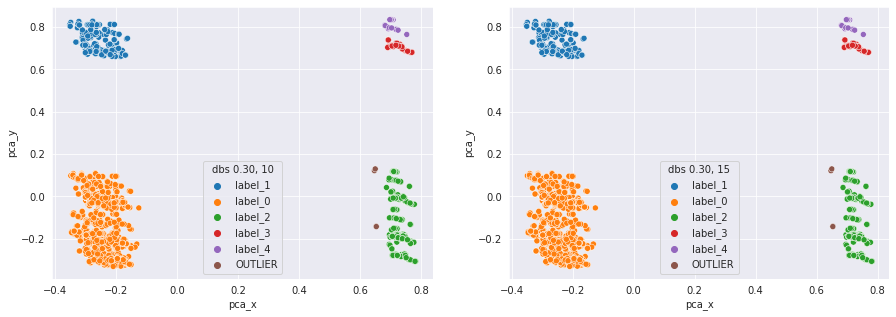

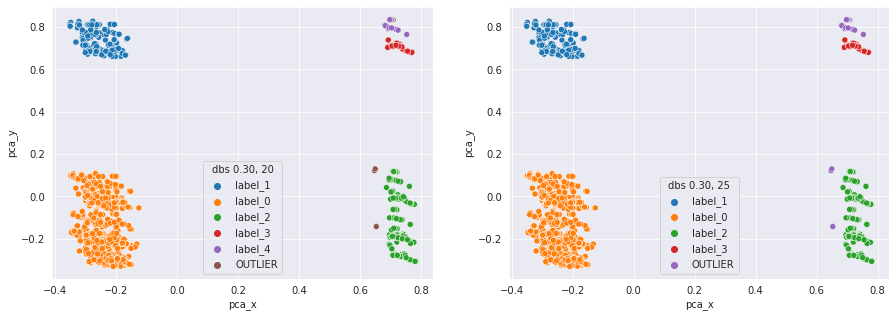

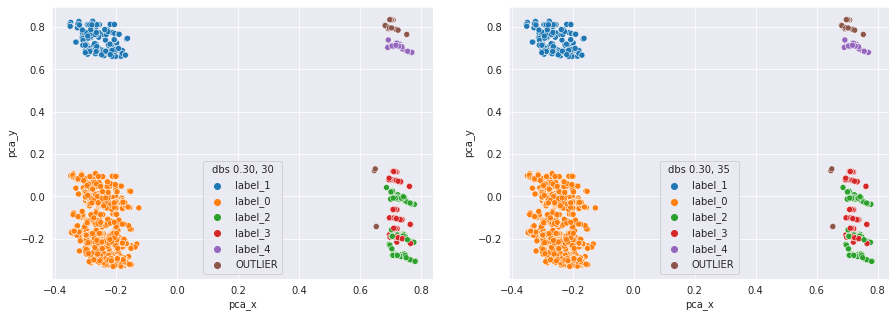

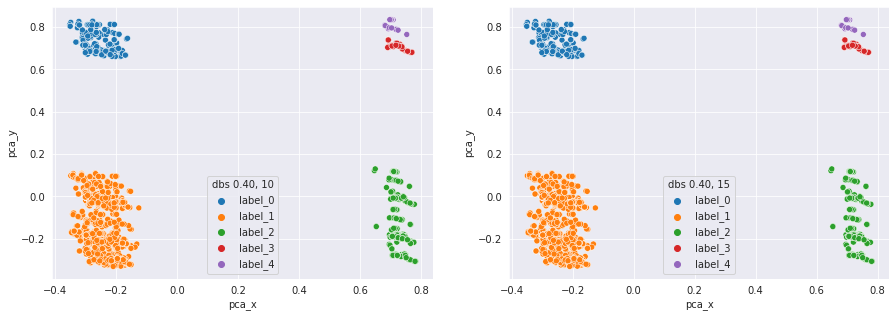

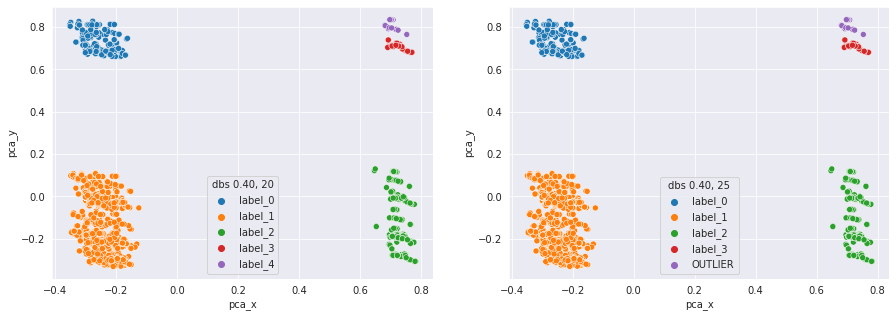

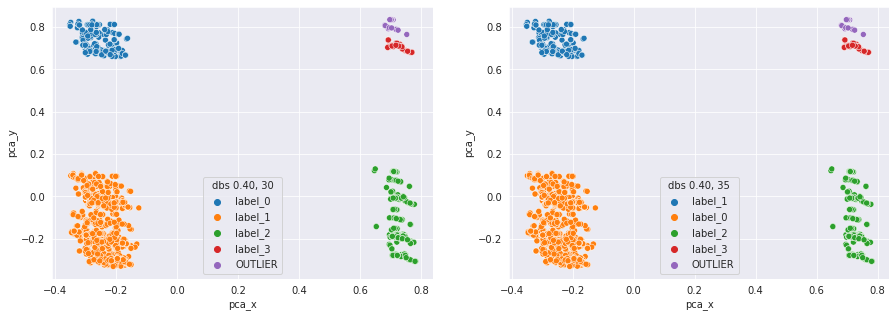

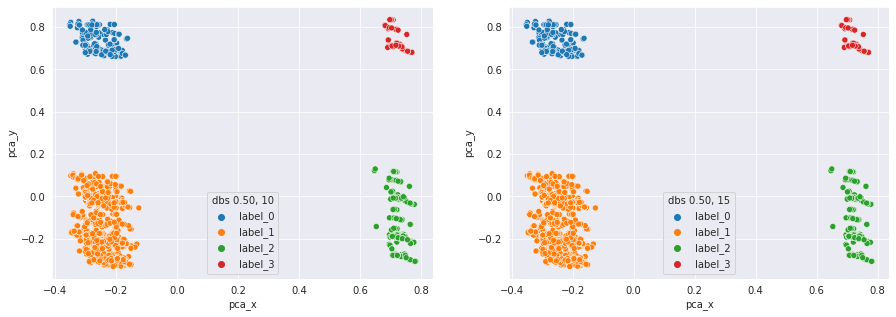

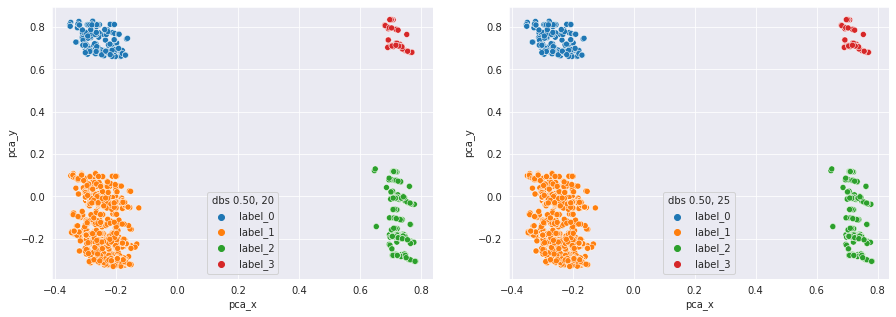

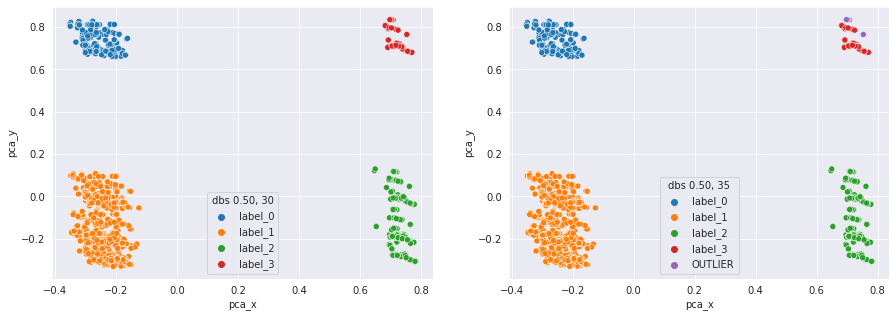

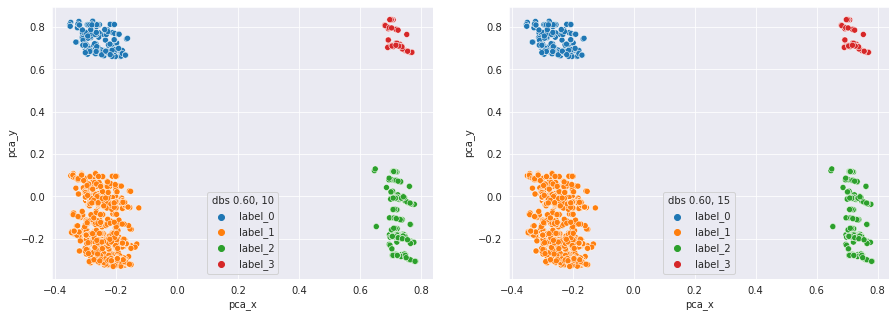

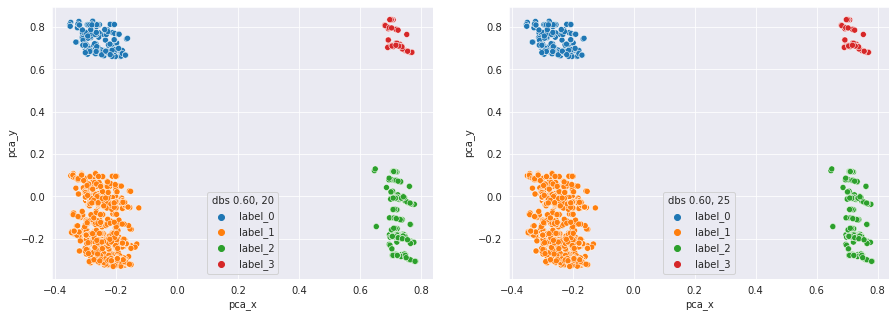

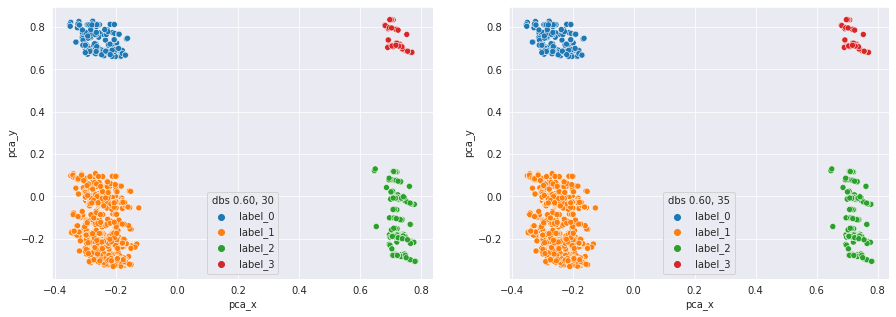

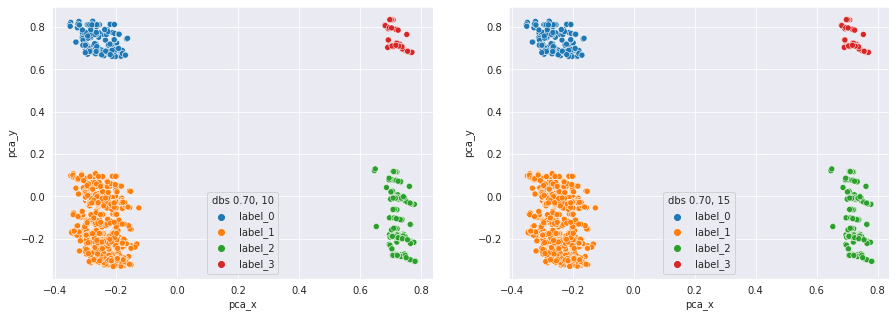

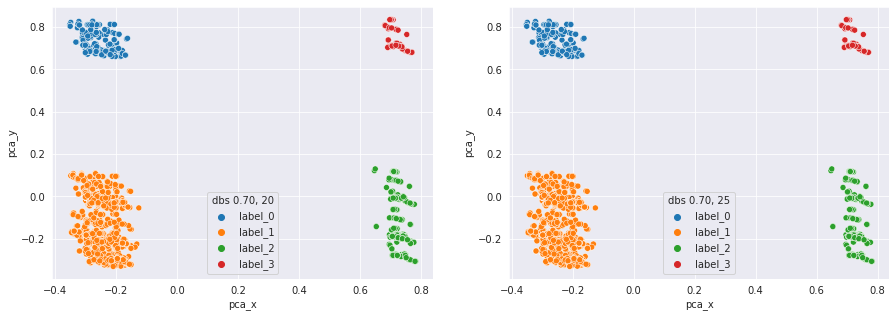

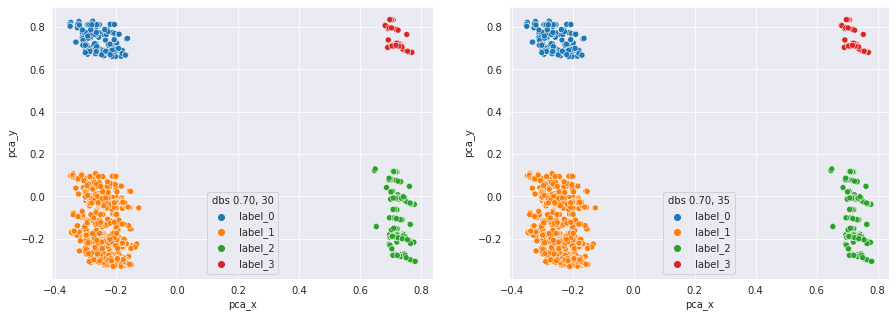

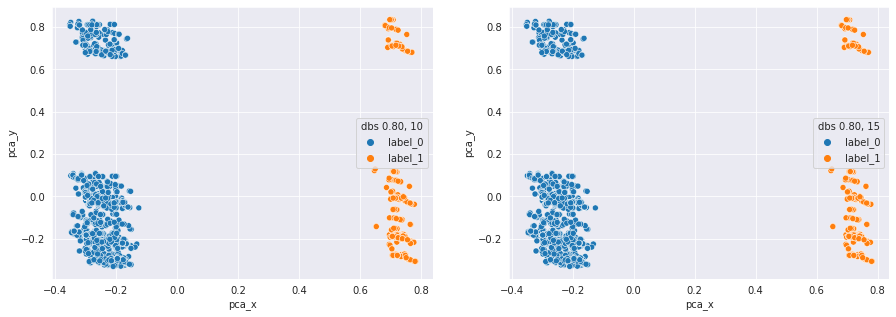

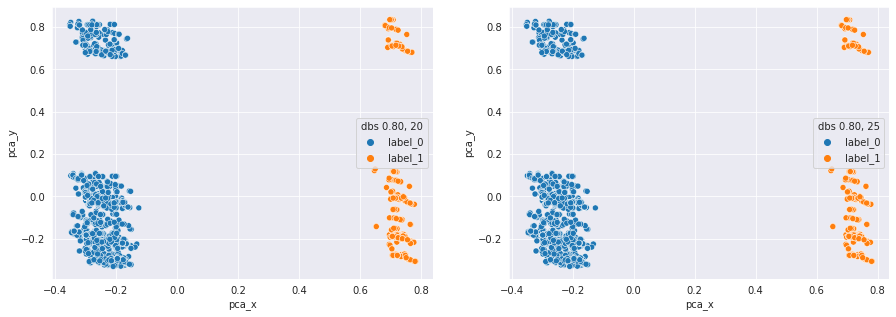

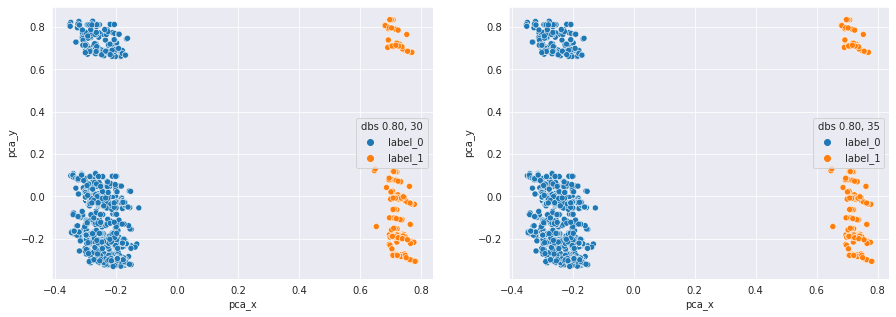

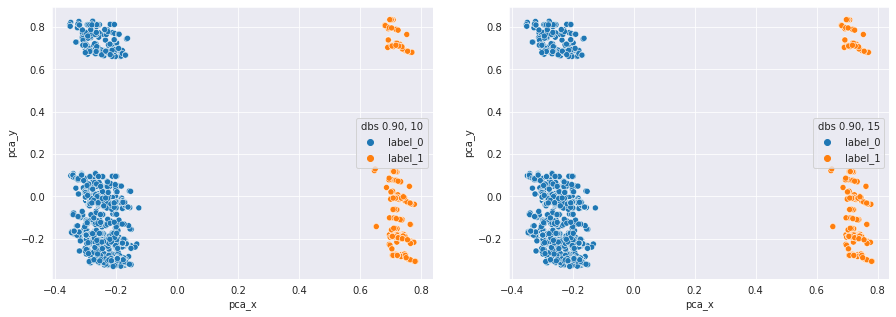

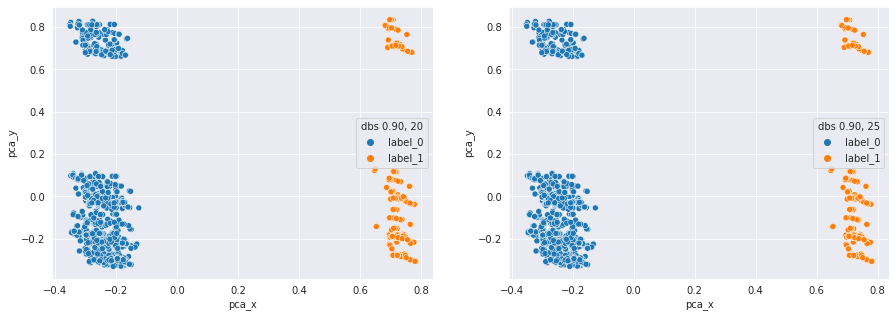

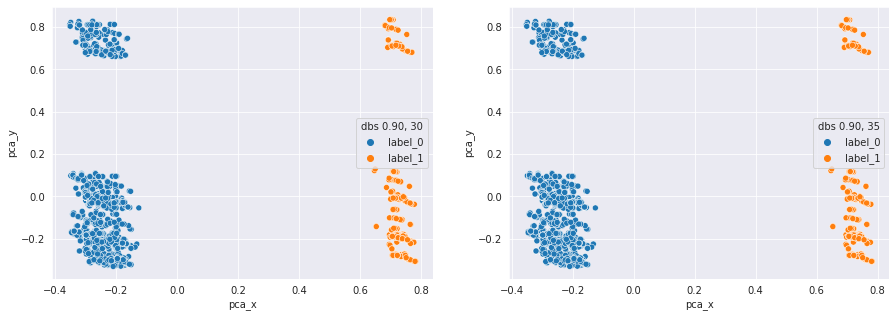

In [ ]:
# Visualiation of clusterring with dbscan tuned with different hyperparameters
for column in dbs_columns:
  fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
  plt.subplot(1,2,1)
  sns.scatterplot(data=X, x="pca_x", y="pca_y", hue=column[0])
  plt.subplot(1,2,2)
  sns.scatterplot(data=X, x="pca_x", y="pca_y", hue=column[1])


From the plots we can see that the best from visual point of view are 4 clusters and the smallest values for such clustering is eps 0.5 and min_samples 10

In [ ]:
# Dbscan model with the smallest optimal hyperparameters
dbscan = DBSCAN(eps=0.5, min_samples=10)
y_dbscan = dbscan.fit_predict(X_scaled)
X['dbscan_label'] = pd.Series(y_dbscan).map(dbscan_labels_mapping)

In [ ]:
# Visualization for the best dbscan model
fig = px.scatter(X, x='pca_x', y='pca_y', color='dbscan_label')
fig.update_layout(title='Earthquake data in 2d PCA space (DBSCAN labels)')
fig.show()

We can see now 4 separate clusters, of course we need to take into account that this is 2-dimentional space, in 4-dimentional it can look differ

# Agglomerative Clustering

For agglomerative clustering before selecting hyperparameters the full dendrogram will be build

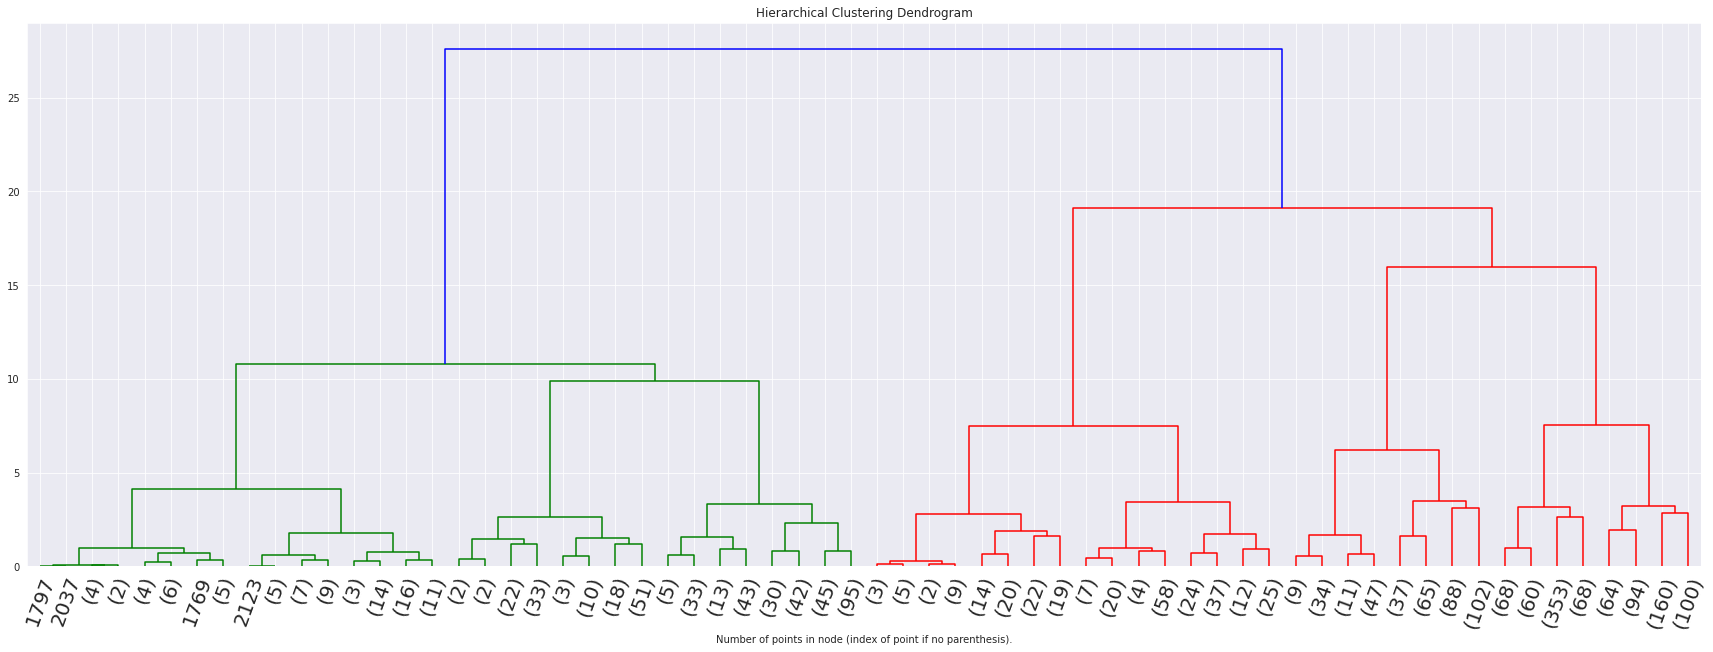

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
agg_cl = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agg_cl = agg_cl.fit(X_scaled)
plot_dend(agg_cl)

Here we can see that 3 or 5 clusters are good choices. But this dendrogram was build with default hyperparameter value 'ward' for linkage. So will try to change it to 'average'

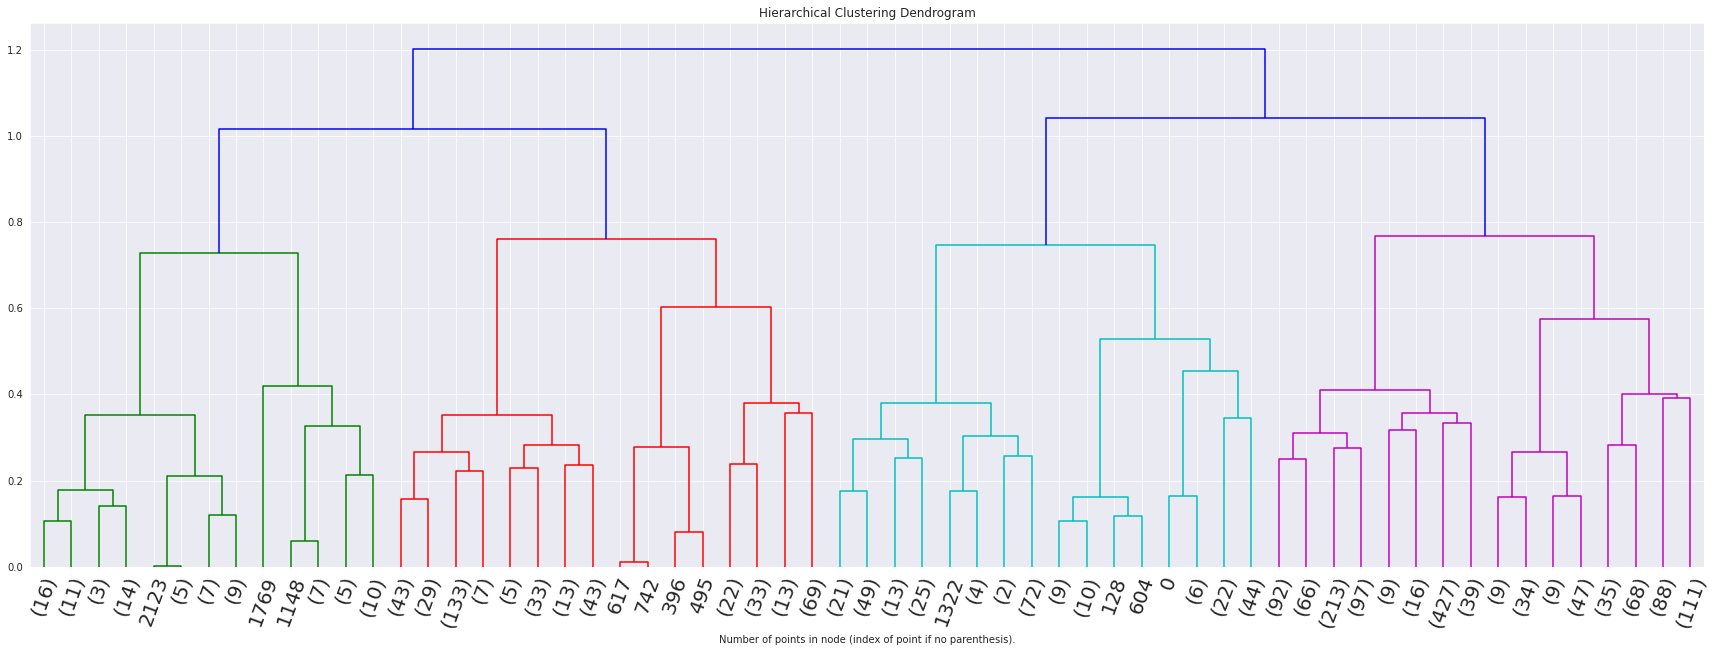

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
agg_cl = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')
agg_cl = agg_cl.fit(X_scaled)
plot_dend(agg_cl)

Now on this dendrogram clustering is more clear and threshold can be on 0.9 level

In [ ]:
# Building agglomerative model with selected hyperparameters
agglomerative = AgglomerativeClustering(distance_threshold=0.9, n_clusters=None, linkage='average')
y_agglomerative = agglomerative.fit_predict(X_scaled)

In [ ]:
# Mapping and assigning labels for agglomerative clustering with 4 clusters
agglomerative_labels_mapping = dict(zip([0, 1, 2, 3, 4, 5, 6, 7], ['label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8']))
X['agglomerative_label_4'] = pd.Series(y_agglomerative).map(agglomerative_labels_mapping)

In [ ]:
# Visualization for the best agglomerative model
fig = px.scatter(X, x='pca_x', y='pca_y', color='agglomerative_label_4')
fig.update_layout(title='Earthquake data in 2d PCA space (Agglomerative clustering labels)')
fig.show()

* The same as for dbscan we can see for agglomerative 4 separate clusters, of course we need to take into account that this is 2-dimentional space, in 4-dimentional it can look differ
* As we will have task for labelling metrics to select most similar model to k-means with optimal clustering, so I'll assign labels also for agglomerative with 5 clusters to check metrics in next section

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=5)
y_agglomerative = agglomerative.fit_predict(X_scaled)
X['agglomerative_label_5'] = pd.Series(y_agglomerative).map(agglomerative_labels_mapping)

# Metrics

## Labelled

Labelled metrics are used when we have ground truth, in our case it is the result of the best k-means clustering.

For labeled metrics Adjusted Mutual Information score and Adjusted Rand index score will be used.

In [ ]:
label_cols = ['kmeans_label', 'dbscan_label', 'agglomerative_label_4', 'agglomerative_label_5']

In [ ]:
for col in label_cols:
    print(f'Adjusted MI score for {col} = {adjusted_mutual_info_score(X["ground_truth"], X[col])}')

Adjusted MI score for kmeans_label = 0.7029519326295122
Adjusted MI score for dbscan_label = 0.8425535690857674
Adjusted MI score for agglomerative_label_4 = 0.8425535690857674
Adjusted MI score for agglomerative_label_5 = 0.9799884579816599


In [ ]:
for col in label_cols:
    print(f'Adjusted rand score for {col} = {adjusted_rand_score(X["ground_truth"], X[col])}')

Adjusted rand score for kmeans_label = 0.40940091274738016
Adjusted rand score for dbscan_label = 0.6617585202922269
Adjusted rand score for agglomerative_label_4 = 0.6617585202922269
Adjusted rand score for agglomerative_label_5 = 0.9847690902119903


* As we can see from those 2 labelled metrics the closest model to K-means with 5 clusters(ground truth) is agglomerative with 5 clusters as it has the highest Adjusted MI score and Adjusted rand score
* Dbscan is not so good but those metrics only show how close model is to that one selected as ground truth

## Unlabelled

For unlabelled Calinski-Harabaz and Silhouette scores will be checked. Ground truth in the list here is just kmeans model with 5 clusters, it was interesting to compare scores with 15 clusters kmeans

In [ ]:
label_cols = ['kmeans_label', 'ground_truth', 'dbscan_label', 'agglomerative_label_4', 'agglomerative_label_5']

In [ ]:
for col in label_cols:
    print(f'Calinsky-Harabaz score for {col} = {calinski_harabasz_score(X_scaled, X[col])}')

Calinsky-Harabaz score for kmeans_label = 2125.817999682414
Calinsky-Harabaz score for ground_truth = 1783.7057152622865
Calinsky-Harabaz score for dbscan_label = 1263.9856145686788
Calinsky-Harabaz score for agglomerative_label_4 = 1263.9856145686788
Calinsky-Harabaz score for agglomerative_label_5 = 1774.2433841465931


In [ ]:
for col in label_cols:
    print(f'Silhouette score for {col} = {silhouette_score(X_scaled, X[col])}')

Silhouette score for kmeans_label = 0.4658343509876901
Silhouette score for ground_truth = 0.52647553345367
Silhouette score for dbscan_label = 0.5121040177115038
Silhouette score for agglomerative_label_4 = 0.5121040177115038
Silhouette score for agglomerative_label_5 = 0.52463590076735


As we can see from the metrics kmeans model with 5 clusters looks like the best one, but for dbscan and 4 clusters metrics are also good, so better to check visual representation of Silhouette score

For n_clusters = 2 The average silhouette_score is : 0.4612051579778659
For n_clusters = 3 The average silhouette_score is : 0.4909378310329093
For n_clusters = 4 The average silhouette_score is : 0.49694319699966666
For n_clusters = 5 The average silhouette_score is : 0.52647553345367


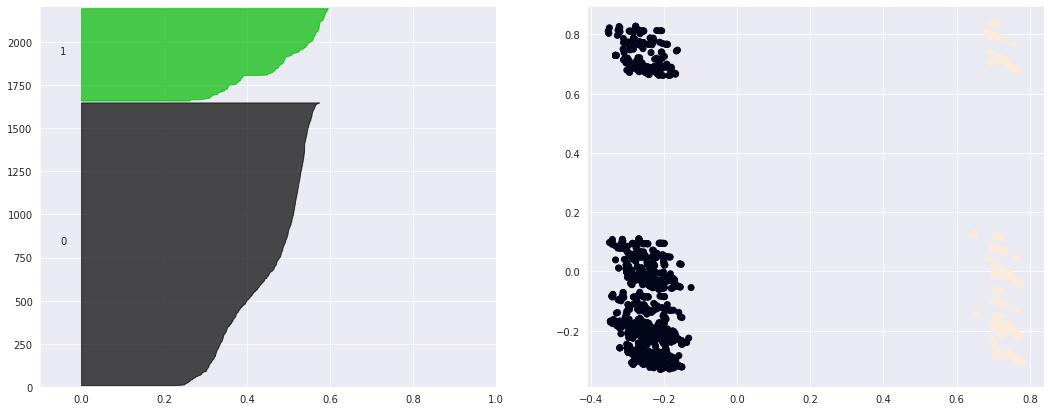

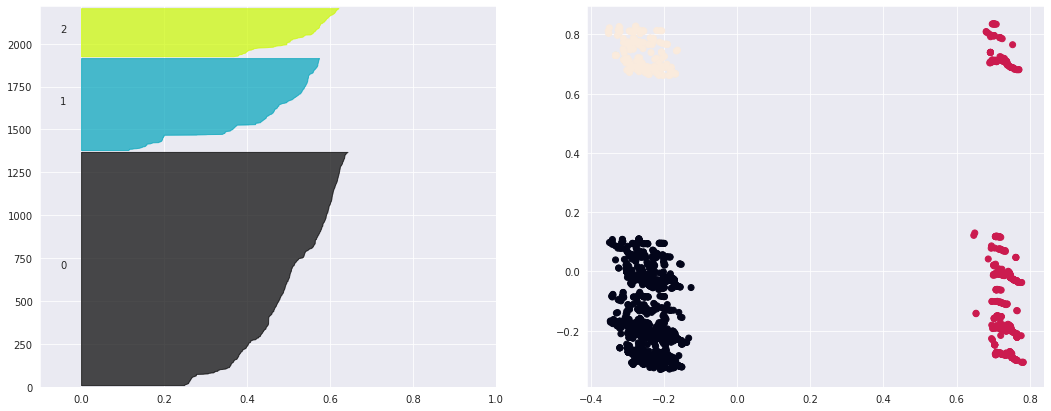

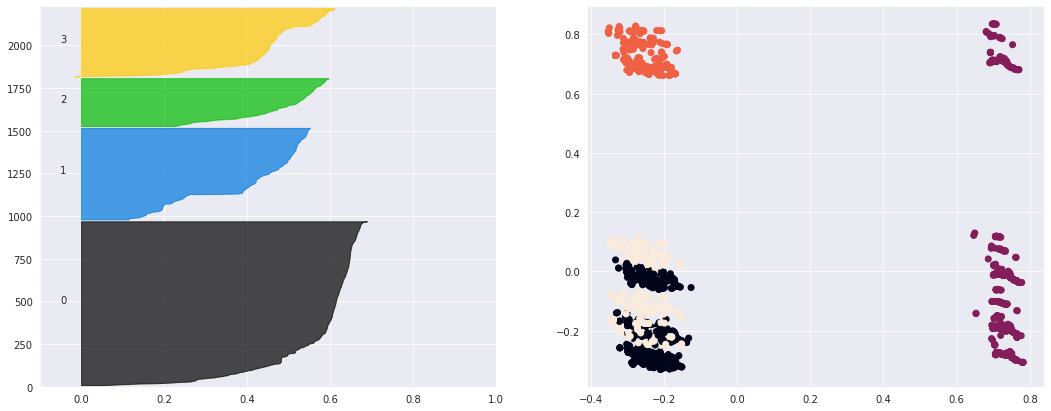

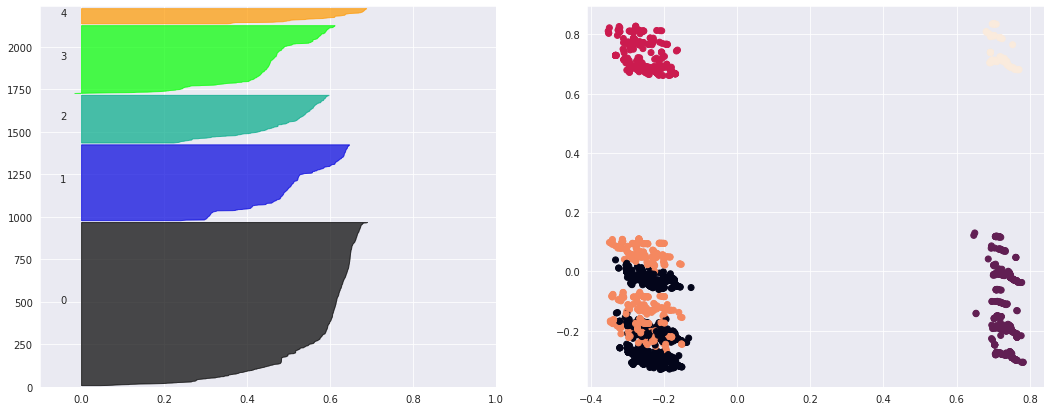

In [ ]:
# Visualization for Silhouette score, Kmeans model
for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X_scaled)
    plot_silhouette(X_scaled, n_clusters, cluster_labels)

So for Kmeans the biggest clustering without negative on plot is 3, but the score itself is better for 5

For n_clusters = 2 The average silhouette_score is : 0.4612051579778659
For n_clusters = 3 The average silhouette_score is : 0.4909378310329093
For n_clusters = 4 The average silhouette_score is : 0.5121040177115038
For n_clusters = 5 The average silhouette_score is : 0.5253439358255925


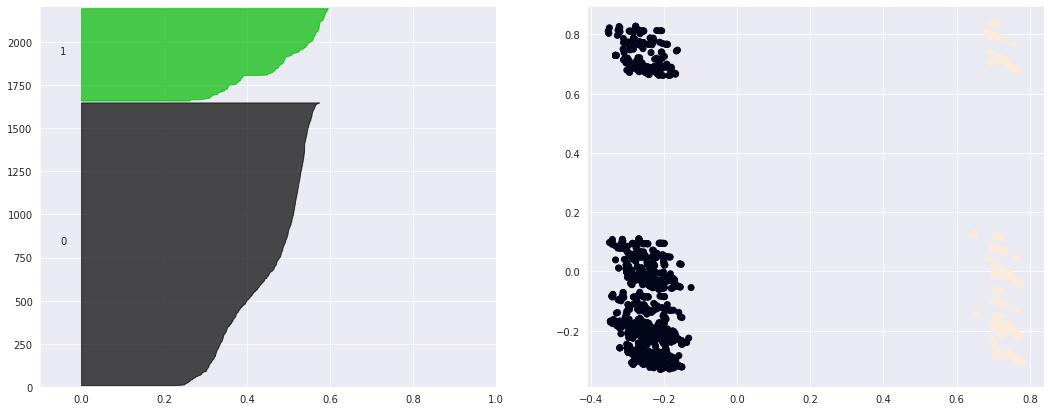

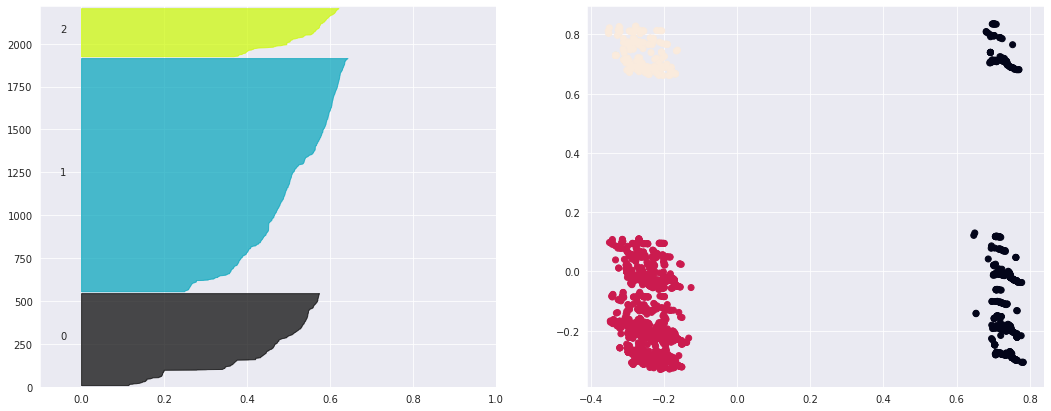

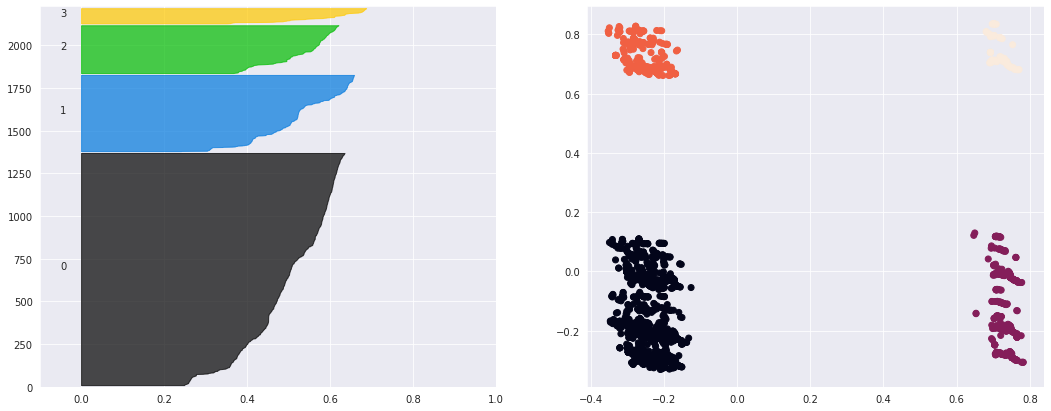

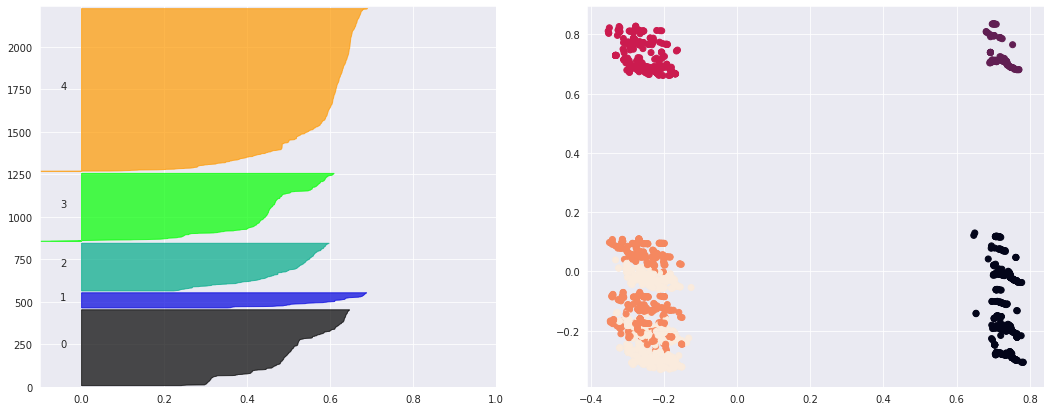

In [ ]:
# Visualization for Silhouette score, Agglomerative Clustering
for n_clusters in range(2, 6):
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    cluster_labels = agg.fit_predict(X_scaled)
    plot_silhouette(X_scaled, n_clusters, cluster_labels)

For Agglomerative Clustering very high score and without negative on plot is for 4 clusters, wich actually the same as for Dbscan model

# Selecting model for world map

* To select the best model for unsupervised clustering not always easy, but in our case visualization helped a lot, as we can see that obviously there are at least 4 clusters
* From metrics also we can see that not good one are for kmeans with 15 clusters, all others are pretty good
* In my opinion the best variant here is Dbscan, so I'll check how data is clustered by features to be sure

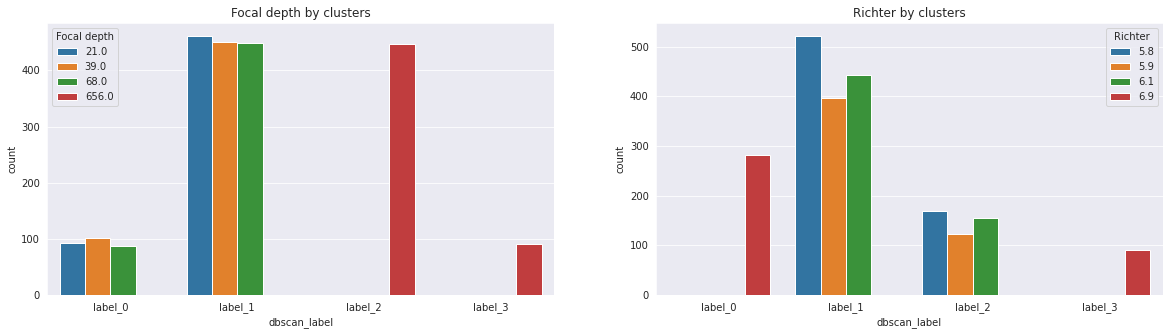

In [ ]:
# Visualization of Focal depth and Richter clustering 
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
sns.countplot(x='dbscan_label', data=X, ax=ax1, hue='Focal depth')
ax1.set_title('Focal depth by clusters')
sns.countplot(x='dbscan_label', data=X, ax=ax2, hue='Richter')
ax2.set_title('Richter by clusters');


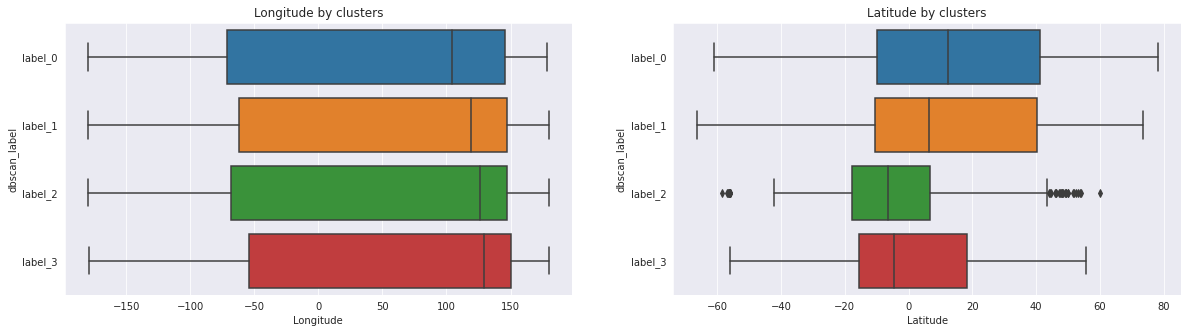

In [ ]:
# Visualization of coordinates clustering
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
sns.boxplot(x='Longitude', data=X, ax=ax1, y='dbscan_label')
ax1.set_title('Longitude by clusters')
sns.boxplot(x='Latitude', data=X, ax=ax2, y='dbscan_label')
ax2.set_title('Latitude by clusters');

As we can see from plots data has very good clusters for earthquake characteristics (depth, strength), and for coordinates not very. I assume it is correct as it is more important to know characteristics of earthquake.

In [ ]:
# Splitting data on 4 dataframes for plotting on world map
df1 = X.loc[X['dbscan_label'] == 'label_0']
df2 = X.loc[X['dbscan_label'] == 'label_1']
df3 = X.loc[X['dbscan_label'] == 'label_2']
df4 = X.loc[X['dbscan_label'] == 'label_3']

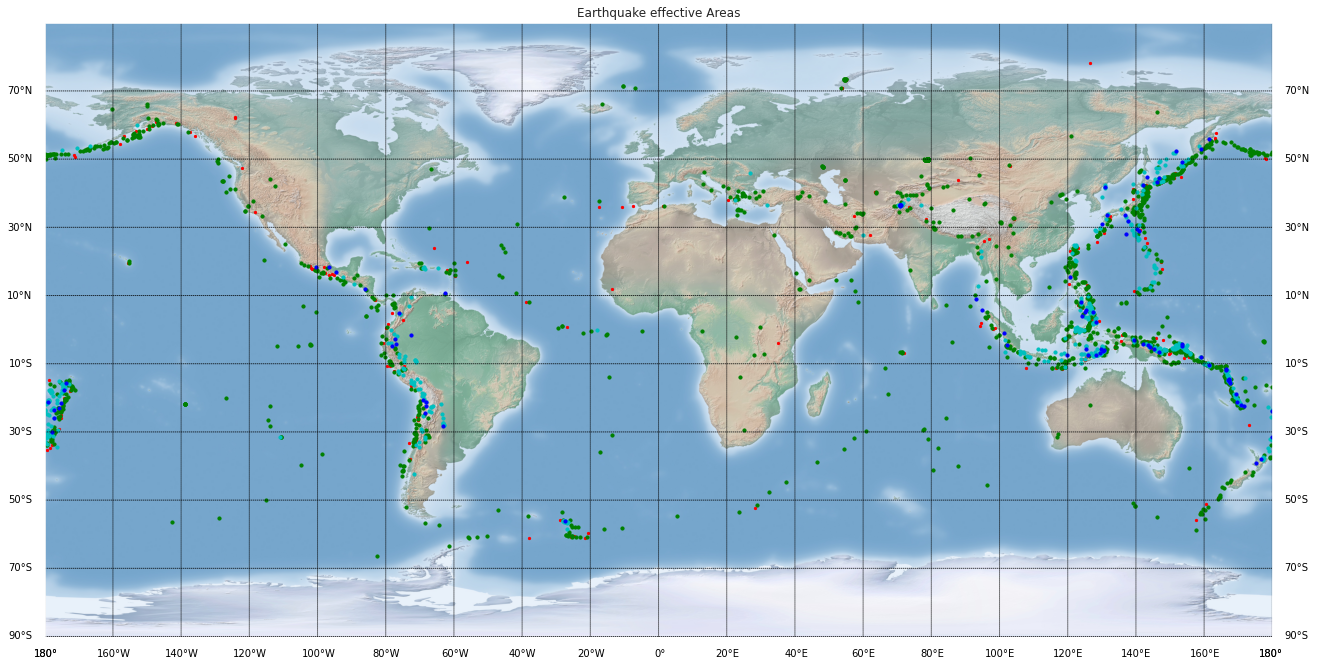

In [ ]:
# Plotting most suitable result on world map
fig = plt.figure(figsize = (22, 20))
wmap = Basemap()
longitudes1 = df1['Longitude'].tolist()
latitudes1 = df1['Latitude'].tolist()
x_1, y_1 = wmap(longitudes1, latitudes1)
longitudes2 = df2['Longitude'].tolist()
latitudes2 = df2['Latitude'].tolist()
x_2, y_2 = wmap(longitudes2, latitudes2)
longitudes3 = df3['Longitude'].tolist()
latitudes3 = df3['Latitude'].tolist()
x_3, y_3 = wmap(longitudes3, latitudes3)
longitudes4 = df4['Longitude'].tolist()
latitudes4 = df4['Latitude'].tolist()
x_4, y_4 = wmap(longitudes4, latitudes4)
plt.title('Earthquake effective Areas')
# wmap.drawcoastlines()
wmap.shadedrelief()
wmap.scatter(x_1, y_1, s = 5, c = 'r')
wmap.scatter(x_2, y_2, s = 10, c = 'g')
wmap.scatter(x_3, y_3, s = 10, c = 'c')
wmap.scatter(x_4, y_4, s = 10, c = 'b')
# draw parallels
wmap.drawparallels(np.arange(-90,90,20),labels=[1,1,0,1]);
# draw meridians
wmap.drawmeridians(np.arange(-180,180,20),labels=[1,1,0,1]);


* On world map we can see that with green are marked earthquakes with the smallest focal depth and richter strength, blue one are with both characteristics high, red one are for high richter but not focal depth, cian are in the middle
* Data is not clustered due to coordinates which is fine as other parameters were taken into consideration

# Conclusions:
* Several approaches of selecting optimal model were used and DBSCAN as density-based model gave us pretty good result of clustering and we've got 4 clusters in 2-dimentional space